In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, accuracy_score, classification_report, 
                           confusion_matrix, roc_curve, ConfusionMatrixDisplay, 
                           precision_score, recall_score, f1_score)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

In [19]:
print("CARGA Y PREPARACIÓN DE DATOS")

# Cargar datos
df = pd.read_csv("heart.csv")

# Detectar target
def detect_target_column(df):
    possible_targets = ['HeartDisease', 'target', 'disease', 'class', 'output']
    for col in possible_targets:
        if col in df.columns:
            return col
    return df.columns[-1]

target_column = detect_target_column(df)
print(f"Target: {target_column}")

# Separar features y target
X = df.drop(target_column, axis=1)
y = df[target_column]

# Preprocesamiento de categóricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Features después de encoding: {X.shape[1]}")

CARGA Y PREPARACIÓN DE DATOS
Target: HeartDisease
X shape: (918, 15), y shape: (918,)
Features después de encoding: 15


In [20]:
print("\nDIVISIÓN ESTRATIFICADA DE DATOS")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")
print(f"Distribución en train: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Distribución en test: {pd.Series(y_test).value_counts().to_dict()}")


DIVISIÓN ESTRATIFICADA DE DATOS
Conjunto de entrenamiento: (734, 15)
Conjunto de prueba: (184, 15)
Distribución en train: {1: 406, 0: 328}
Distribución en test: {1: 102, 0: 82}


In [21]:
print("\nCONFIGURACIÓN AVANZADA DE MODELOS")
models_config = {
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1, 0.15],
            "clf__max_depth": [3, 4, 5],
            "clf__min_samples_split": [2, 5]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [5, 10, None],
            "clf__min_samples_split": [2, 5],
            "clf__min_samples_leaf": [1, 2]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "params": {
            "clf__C": [0.1, 1, 10],
            "clf__solver": ["liblinear", "saga"],
            "clf__penalty": ["l1", "l2"]
        }
    },
    "SVC": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "clf__C": [0.1, 1, 10],
            "clf__gamma": [0.01, 0.1, 1],
            "clf__kernel": ["rbf", "poly"]
        }
    }
}

print("Modelos configurados para validación avanzada:")
for name in models_config.keys():
    print(f"   • {name}")


CONFIGURACIÓN AVANZADA DE MODELOS
Modelos configurados para validación avanzada:
   • GradientBoosting
   • RandomForest
   • LogisticRegression
   • SVC


In [22]:
def train_with_cross_validation(X_train, y_train, model, param_grid, model_name):
    """
    Entrenamiento con Pipeline y Validación Cruzada Estratificada
    """
    # Seleccionar scaler
    if model_name in ["SVC", "KNeighbors"]:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    
    # Crear pipeline
    pipe = Pipeline([
        ("scaler", scaler),
        ("clf", model)
    ])
    
    # Configurar GridSearchCV con validación cruzada estratificada
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    grid = GridSearchCV(
        pipe, 
        param_grid, 
        cv=cv_strategy, 
        scoring="roc_auc",
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )
    
    print(f"Entrenando {model_name} con validación cruzada...")
    grid.fit(X_train, y_train)
    
    return grid, cv_strategy

In [23]:
print("ENTRENAMIENTO CON VALIDACIÓN CRUZADA ESTRATIFICADA")

results_cv = {}

for name, config in models_config.items():
    print(f"\nENTRENANDO {name.upper()}")
    print("-" * 30)
    
    try:
        grid, cv_strategy = train_with_cross_validation(
            X_train, y_train, config["model"], config["params"], name
        )
        
        # Evaluar en test
        y_pred = grid.predict(X_test)
        y_pred_proba = grid.predict_proba(X_test)[:, 1]
        
        # Métricas
        auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Validación cruzada adicional
        cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, 
                                  cv=cv_strategy, scoring='roc_auc')
        
        results_cv[name] = {
            "model": grid.best_estimator_,
            "grid": grid,
            "auc": auc,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "best_params": grid.best_params_,
            "cv_mean": cv_scores.mean(),
            "cv_std": cv_scores.std(),
            "y_pred": y_pred,
            "y_pred_proba": y_pred_proba
        }
        
        print(f"    {name}")
        print(f"    AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")
        print(f"    CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        print(f"    Best params: {grid.best_params_}")
        
    except Exception as e:
        print(f"   Error en {name}: {e}")

print(f"\nEntrenamiento completado: {len(results_cv)}/{len(models_config)} modelos")

ENTRENAMIENTO CON VALIDACIÓN CRUZADA ESTRATIFICADA

ENTRENANDO GRADIENTBOOSTING
------------------------------
Entrenando GradientBoosting con validación cruzada...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
    GradientBoosting
    AUC: 0.9393, Accuracy: 0.8967
    CV AUC: 0.9307 (±0.0201)
    Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

ENTRENANDO RANDOMFOREST
------------------------------
Entrenando RandomForest con validación cruzada...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
    RandomForest
    AUC: 0.9311, Accuracy: 0.8750
    CV AUC: 0.9311 (±0.0244)
    Best params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}

ENTRENANDO LOGISTICREGRESSION
------------------------------
Entrenando LogisticRegression con validación cruzada...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
    LogisticRegre

In [24]:
print("RANKING DE MODELOS CON VALIDACIÓN CRUZADA")

# Crear DataFrame comparativo
cv_comparison = []
for name, result in results_cv.items():
    cv_comparison.append({
        "Model": name,
        "Test_AUC": result["auc"],
        "CV_AUC_Mean": result["cv_mean"],
        "CV_AUC_Std": result["cv_std"],
        "Accuracy": result["accuracy"],
        "Precision": result["precision"],
        "Recall": result["recall"],
        "F1_Score": result["f1"],
        "Best_Params": str(result["best_params"])
    })

cv_ranking_df = pd.DataFrame(cv_comparison)
cv_ranking_df = cv_ranking_df.sort_values("Test_AUC", ascending=False)
cv_ranking_df.reset_index(drop=True, inplace=True)

# Mostrar ranking con estilo
styled_cv = cv_ranking_df.style.background_gradient(
    subset=['Test_AUC', 'CV_AUC_Mean', 'Accuracy', 'F1_Score'], 
    cmap='YlGnBu'
).format({
    'Test_AUC': '{:.4f}',
    'CV_AUC_Mean': '{:.4f}',
    'CV_AUC_Std': '{:.4f}',
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1_Score': '{:.4f}'
})

display(styled_cv)

# Mejor modelo
best_cv_model = cv_ranking_df.iloc[0]
print(f"\nMEJOR MODELO: {best_cv_model['Model']}")
print(f"    Test AUC: {best_cv_model['Test_AUC']:.4f}")
print(f"    CV AUC: {best_cv_model['CV_AUC_Mean']:.4f} (±{cv_ranking_df.iloc[0]['CV_AUC_Std']:.4f})")
print(f"    Accuracy: {best_cv_model['Accuracy']:.4f}")

RANKING DE MODELOS CON VALIDACIÓN CRUZADA


,Model,Test_AUC,CV_AUC_Mean,CV_AUC_Std,Accuracy,Precision,Recall,F1_Score,Best_Params
0,GradientBoosting,0.9393,0.9307,0.0201,0.8967,0.8952,0.9216,0.9082,"{'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}"
1,LogisticRegression,0.9320,0.9258,0.0359,0.8859,0.8716,0.9314,0.9005,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}"
2,RandomForest,0.9311,0.9311,0.0244,0.8750,0.8762,0.9020,0.8889,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}"
3,SVC,0.9311,0.9230,0.0406,0.8641,0.8468,0.9216,0.8826,"{'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}"



MEJOR MODELO: GradientBoosting
    Test AUC: 0.9393
    CV AUC: 0.9307 (±0.0201)
    Accuracy: 0.8967


VISUALIZACIÓN DE RESULTADOS CON VALIDACIÓN CRUZADA


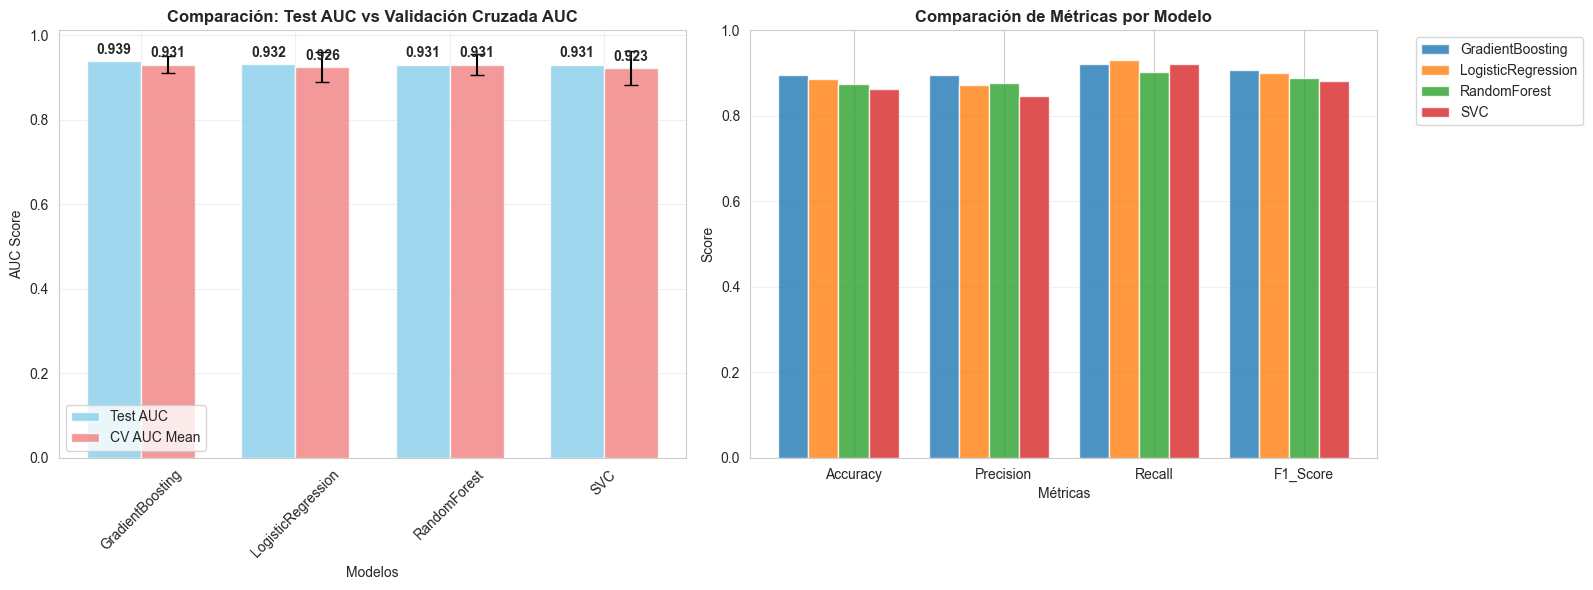

In [25]:
print("VISUALIZACIÓN DE RESULTADOS CON VALIDACIÓN CRUZADA")
# 1. Comparación Test AUC vs CV AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Test AUC vs CV AUC
models = cv_ranking_df['Model']
test_auc = cv_ranking_df['Test_AUC']
cv_auc = cv_ranking_df['CV_AUC_Mean']
cv_std = cv_ranking_df['CV_AUC_Std']

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, test_auc, width, label='Test AUC', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, cv_auc, width, label='CV AUC Mean', yerr=cv_std, 
                color='lightcoral', alpha=0.8, capsize=5)

ax1.set_xlabel('Modelos')
ax1.set_ylabel('AUC Score')
ax1.set_title('Comparación: Test AUC vs Validación Cruzada AUC', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, value in zip(bars1, test_auc):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
for bar, value in zip(bars2, cv_auc):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Métricas múltiples
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
metrics_data = cv_ranking_df[metrics].values

x_metrics = np.arange(len(metrics))
width_metrics = 0.2

for i, model in enumerate(models):
    offset = width_metrics * (i - len(models)/2)
    ax2.bar(x_metrics + offset, metrics_data[i], width_metrics, label=model, alpha=0.8)

ax2.set_xlabel('Métricas')
ax2.set_ylabel('Score')
ax2.set_title('Comparación de Métricas por Modelo', fontweight='bold')
ax2.set_xticks(x_metrics)
ax2.set_xticklabels(metrics)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


CURVAS ROC COMPARATIVAS


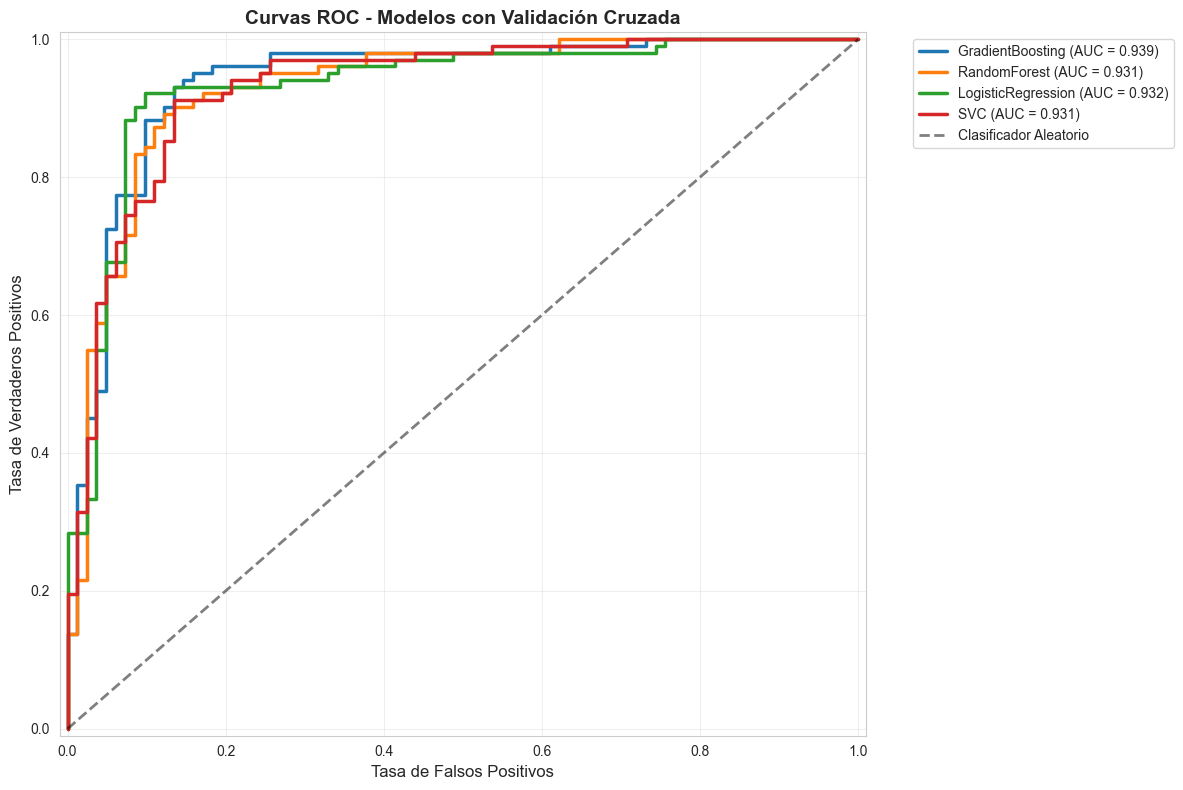

In [26]:
print("\nCURVAS ROC COMPARATIVAS")
plt.figure(figsize=(12, 8))

for name, result in results_cv.items():
    fpr, tpr, _ = roc_curve(y_test, result["y_pred_proba"])
    auc = result["auc"]
    plt.plot(fpr, tpr, linewidth=2.5, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label="Clasificador Aleatorio")
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC - Modelos con Validación Cruzada', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.tight_layout()
plt.show()


MATRICES DE CONFUSIÓN


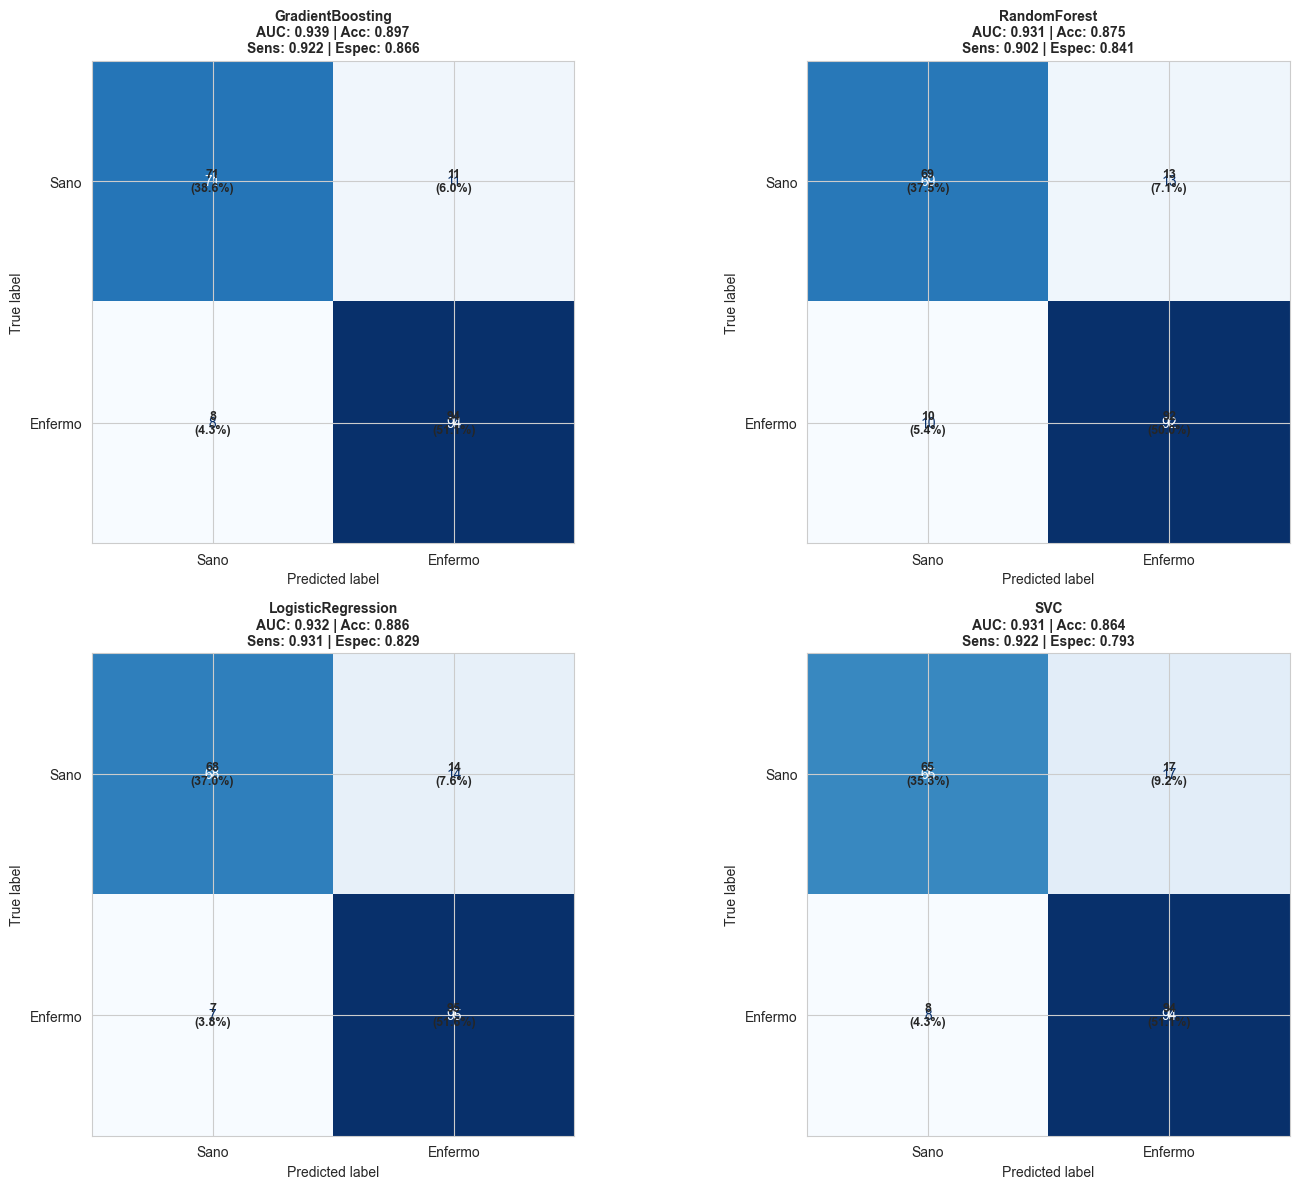

In [27]:
print("\nMATRICES DE CONFUSIÓN")

n_models = len(results_cv)
n_cols = 2
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6*n_rows))
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for idx, (name, result) in enumerate(results_cv.items()):
    if idx < len(axes):
        cm = confusion_matrix(y_test, result["y_pred"])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                    display_labels=['Sano', 'Enfermo'])
        disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
        
        # Calcular métricas específicas
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        axes[idx].set_title(f'{name}\nAUC: {result["auc"]:.3f} | ' 
                          f'Acc: {result["accuracy"]:.3f}\n'
                          f'Sens: {result["recall"]:.3f} | Espec: {specificity:.3f}', 
                          fontweight='bold', fontsize=10)
        
        # Añadir anotaciones
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[idx].text(j, i, f'{cm[i, j]}\n({cm[i, j]/cm.sum():.1%})',
                             ha='center', va='center', fontweight='bold', fontsize=9)

# Ocultar ejes vacíos
for idx in range(len(results_cv), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

ANÁLISIS DE ROBUSTEZ CON VALIDACIÓN CRUZADA


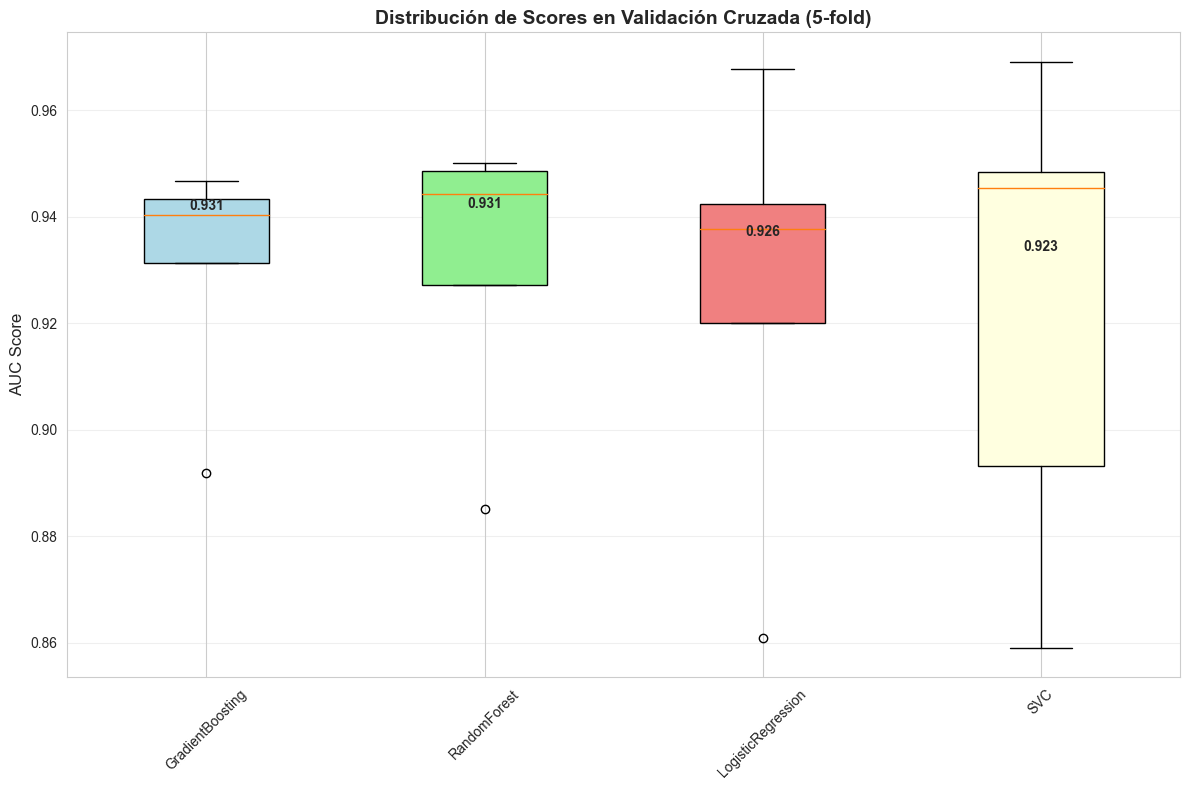


ESTADÍSTICAS DE VALIDACIÓN CRUZADA:

🔹 GradientBoosting:
   Media: 0.9307
   Desviación: 0.0201
   Rango: [0.8919, 0.9468]

🔹 RandomForest:
   Media: 0.9311
   Desviación: 0.0244
   Rango: [0.8851, 0.9501]

🔹 LogisticRegression:
   Media: 0.9258
   Desviación: 0.0359
   Rango: [0.8608, 0.9678]

🔹 SVC:
   Media: 0.9230
   Desviación: 0.0406
   Rango: [0.8590, 0.9691]


In [28]:
print("ANÁLISIS DE ROBUSTEZ CON VALIDACIÓN CRUZADA")

# Obtener scores de CV para cada modelo
cv_scores_details = {}
for name, result in results_cv.items():
    cv_scores = cross_val_score(result["model"], X_train, y_train, 
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                              scoring='roc_auc')
    cv_scores_details[name] = cv_scores

# Boxplot de scores de CV
plt.figure(figsize=(12, 8))
box_data = [cv_scores_details[name] for name in results_cv.keys()]
box_plot = plt.boxplot(box_data, labels=results_cv.keys(), patch_artist=True)

# Colorear las cajas
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('AUC Score', fontsize=12)
plt.title('Distribución de Scores en Validación Cruzada (5-fold)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

# Añadir valores medios
for i, (name, scores) in enumerate(cv_scores_details.items()):
    mean_score = np.mean(scores)
    plt.text(i + 1, mean_score + 0.01, f'{mean_score:.3f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Mostrar estadísticas de CV
print("\nESTADÍSTICAS DE VALIDACIÓN CRUZADA:")
for name, scores in cv_scores_details.items():
    print(f"\n🔹 {name}:")
    print(f"   Media: {np.mean(scores):.4f}")
    print(f"   Desviación: {np.std(scores):.4f}")
    print(f"   Rango: [{np.min(scores):.4f}, {np.max(scores):.4f}]")

In [29]:
print("GUARDANDO MEJOR MODELO PARA PRODUCCIÓN")

# Identificar mejor modelo
best_model_name_cv = cv_ranking_df.iloc[0]['Model']
best_model_cv = results_cv[best_model_name_cv]['model']

# Guardar modelo
model_path_cv = "app/model_cv.joblib"
joblib.dump(best_model_cv, model_path_cv)

print(f"Mejor modelo guardado: {best_model_name_cv}")
print(f"Ruta: {model_path_cv}")
print(f"Performance:")
print(f"   • Test AUC: {results_cv[best_model_name_cv]['auc']:.4f}")
print(f"   • CV AUC: {results_cv[best_model_name_cv]['cv_mean']:.4f} "
      f"(±{results_cv[best_model_name_cv]['cv_std']:.4f})")
print(f"   • Accuracy: {results_cv[best_model_name_cv]['accuracy']:.4f}")
print(f"   • F1-Score: {results_cv[best_model_name_cv]['f1']:.4f}")
print(f"Parámetros optimizados: {results_cv[best_model_name_cv]['best_params']}")

# También guardar todos los resultados para análisis futuro
results_path = "app/training_results.pkl"
import pickle
with open(results_path, 'wb') as f:
    pickle.dump(results_cv, f)
print(f"Resultados guardados en: {results_path}")

GUARDANDO MEJOR MODELO PARA PRODUCCIÓN
Mejor modelo guardado: GradientBoosting
Ruta: app/model_cv.joblib
Performance:
   • Test AUC: 0.9393
   • CV AUC: 0.9307 (±0.0201)
   • Accuracy: 0.8967
   • F1-Score: 0.9082
Parámetros optimizados: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Resultados guardados en: app/training_results.pkl


In [32]:
print("CONCLUSIONES FINALES - ETAPA 2: MODELADO CON VALIDACIÓN SEGURA")
print("IMPLEMENTACIONES COMPLETADAS:")
print("   • División estratificada de datos antes del escalado")
print("   • Pipeline con GridSearchCV para cada modelo")
print("   • Validación cruzada estratificada (5-fold)")
print("   • Optimización exhaustiva de hiperparámetros")
print("   • Evaluación con múltiples métricas (AUC, Accuracy, Precision, Recall, F1)")
print("   • Análisis de robustez con validación cruzada")

print(f"\nMEJOR MODELO SELECCIONADO: {best_model_name_cv}")
print(f"   Test AUC: {results_cv[best_model_name_cv]['auc']:.4f}")
print(f"   CV AUC: {results_cv[best_model_name_cv]['cv_mean']:.4f} "
      f"(±{results_cv[best_model_name_cv]['cv_std']:.4f})")
print(f"    Accuracy: {results_cv[best_model_name_cv]['accuracy']:.4f}")

print("\nCOMPARACIÓN CON ETAPA 1:")
print(f"   • Mejor AUC Etapa 1: 0.9372 (GradientBoosting)")
print(f"   • Mejor AUC Etapa 2: {results_cv[best_model_name_cv]['auc']:.4f} ({best_model_name_cv})")
print(f"\nModelo listo para producción: {model_path_cv}")

CONCLUSIONES FINALES - ETAPA 2: MODELADO CON VALIDACIÓN SEGURA
IMPLEMENTACIONES COMPLETADAS:
   • División estratificada de datos antes del escalado
   • Pipeline con GridSearchCV para cada modelo
   • Validación cruzada estratificada (5-fold)
   • Optimización exhaustiva de hiperparámetros
   • Evaluación con múltiples métricas (AUC, Accuracy, Precision, Recall, F1)
   • Análisis de robustez con validación cruzada

MEJOR MODELO SELECCIONADO: GradientBoosting
   Test AUC: 0.9393
   CV AUC: 0.9307 (±0.0201)
    Accuracy: 0.8967

COMPARACIÓN CON ETAPA 1:
   • Mejor AUC Etapa 1: 0.9372 (GradientBoosting)
   • Mejor AUC Etapa 2: 0.9393 (GradientBoosting)

Modelo listo para producción: app/model_cv.joblib
